# Downscaling rasters thanks to dask

In this notebook we will look at a concrete case of data aggregation, with the example of changing the resolution using dask.

Dask is a Python library that enables calculations to be parallelized and large quantities of data to be handled in a scalable way, using available resources (CPU, memory, etc.). Unlike tools such as Pandas or NumPy, Dask allows you to work on data sets that exceed the available RAM memory by chunking the data into smaller pieces (chunks) and parallelizing calculations.
Dask works with lazy computation: instead of executing immediately, it builds a task graph. Calculations are only executed when the final result is explicitly requested (for example, by calling .compute()).

Dask offers a wide range of [modules](https://docs.dask.org/en/stable/#how-to-use-dask) (dask dataframe...) that can be used to distribute calculations. In this notebook we will focus on the use of [dask-arrays](https://docs.dask.org/en/stable/array.html) to manipulate raster data.

In order to change the resolution, we will look at two possible methods. One of them will prove less effective than the other, which will allow us to establish some general principles to follow for optimal use of Dask. The first one will use [map_blocks](https://docs.dask.org/en/stable/generated/dask.array.map_blocks.html) and the second one only [dask.array.mean](https://docs.dask.org/en/stable/generated/dask.array.mean.html)

For this tutorial, we will use a Sentinel-2 acquisition stored on the local disk. We will target the storage directory under the variable ``sentinel_2_dir``. Users can modify this directory and the associated paths.

## Python scripts

### Import libraries

First let's import libraries needed for this tutorial and create our dask [LocalCluster](https://docs.dask.org/en/stable/deploying-python.html#localcluster) which allow us to create workers and use [dask's dashboard](https://docs.dask.org/en/latest/dashboard.html).


In [1]:
from pathlib import Path

from typing import List, Tuple, Union, Dict
import dask.array as da
import numpy as np
import rasterio
import rioxarray as rxr
from dask import delayed
from dask.distributed import Client, LocalCluster
from rasterio.transform import Affine

from utils import create_map_with_rasters

cluster = LocalCluster()
client = Client(cluster)

print("Dask Dashboard: ", client.dashboard_link)
client

Dask Dashboard:  http://127.0.0.1:8787/status


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 15.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37485,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 15.49 GiB
Comm: tcp://127.0.0.1:33481,Total threads: 2
Dashboard: http://127.0.0.1:33409/status,Memory: 3.87 GiB
Nanny: tcp://127.0.0.1:41811,


Dask return an url where the dashboard is availaible (usually http://127.0.0.1:8787/status). This is not a tutorial on how to use this dashboard, but we recommend using it in a separate window while using this notebook.

### Open raster thanks to rioxarray

Here we are going to open the raster data required for this tutorial, the RGB bands from a Sentinel-2 acquisition. To do this, we're going to use rioxarray and, more specifically, the [open_rasterio](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray-open-rasterio) method, which opens the images lazily (without loading data into memory) and returns a `dask.array` object. 
From this method we will use the ``chunks`` and ``lock`` arguments, which respectively set a chunk size and limit access to the data to one thread at a time to avoid read problems. Here ``chunks`` is set to ``True`` to allow dask to automatically size chunks.


In [2]:
def open_raster_and_get_metadata(raster_paths: List[str], chunks: Union[int, Tuple, Dict, None]):
    """
    Opens multiple raster files, extracts shared geospatial metadata, 
    and returns the concatenated data along with resolution and CRS info.

    Parameters:
    -----------
    raster_paths : List[str]
        Paths to the raster files.
    chunks : Union[int, Tuple, Dict, bool, None]
        Chunk sizes for Dask (bands, height, width).

    Returns:
    --------
    Tuple[dask.array.Array, float, float, float, float, Union[str, CRS]]
        Concatenated raster data, x and y resolution, top-left coordinates, and CRS.
    """
    results = []
    for raster_path in raster_paths:
        with rxr.open_rasterio(raster_path, chunks=chunks, lock=True) as tif:
            reprojection = tif
            transform = reprojection.rio.transform()
            crs = reprojection.rio.crs
            x_res = transform[0]
            y_res = -transform[4]
            top_left_x = transform[2]
            top_left_y = transform[5]
            results.append(reprojection)

    return da.concatenate(results), x_res, y_res, top_left_x, top_left_y, crs

# Paths to RGB Sentinel-2 bands
sentinel_2_dir = "." # change it for your own directory
s2_b4 = f"{sentinel_2_dir}/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_FRE_B4.tif"
s2_b3 = f"{sentinel_2_dir}/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_FRE_B3.tif"
s2_b2 = f"{sentinel_2_dir}/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_FRE_B2.tif"

reading_chunks = True
input_data_array, x_res, y_res, top_left_x, top_left_y, crs = open_raster_and_get_metadata([s2_b4, s2_b3, s2_b2], reading_chunks)

The role of our ``open_raster_and_get_metadata`` function is to read and concatenate the images on the disk. It returns a dask object as well as various spatial information required for the rest of the tutorial.

#### ⚠️ Warning:
it is important to use as many dask-native functions as possible so that all operations are carried out lazily and do not load data into memory. That's why we are using [da.concatenate](https://docs.dask.org/en/stable/generated/dask.array.concatenate.html) instead of numpy.concatenate or equivalent.

In [3]:
input_data_array

dask.array<concatenate, shape=(3, 10980, 10980), dtype=int16, chunksize=(1, 6111, 10980), chunktype=numpy.ndarray>

By displaying the contents of the ``input_data_array`` variable we can see how dask has chunked the data. Given that the input data is a 3-dimensional array (RGB) of size 10980x10980, with automatic chunking dask slice the data into 6 chunks.

### Downscaling input data, map_blocks dask functionality

Now that our data is in memory, we can define our aggregation function. If we consider that we are grouping a certain number of pixels into a single new pixel (where each output pixel represents a 100x100 pixel window in the input data), we must adhere to the following constraints:

$$ \text{new\_xysize} = \text{scale\_factor} \times \text{old\_xysize}, \quad \text{where } \text{new\_xysize}, \text{old\_xysize} \in \mathbb{N}^{*} $$

Then we have to choice ``scale_factor`` as a divisor of ``10980`` which is our native x and y size.

In [4]:
def get_divisors(n):
    """
    Return a list of all divisors of the given integer.

    Parameters
    ----------
    n : int
        The integer for which to find the divisors.

    Returns
    -------
    list
        A list of divisors of the integer n.
    """
    if n <= 0:
        raise ValueError("The input must be a positive integer.")

    divisors = []
    for i in range(1, n + 1):
        if n % i == 0:
            divisors.append(i)
    return divisors
print(get_divisors(10980))

[1, 2, 3, 4, 5, 6, 9, 10, 12, 15, 18, 20, 30, 36, 45, 60, 61, 90, 122, 180, 183, 244, 305, 366, 549, 610, 732, 915, 1098, 1220, 1830, 2196, 2745, 3660, 5490, 10980]


Here we're going to use the [map_blocks](https://docs.dask.org/en/stable/generated/dask.array.map_blocks.html) function which, at first glance, lets you map any function to blocks in a dask array.

In [5]:
def apply_reduction_mean_mapblock(data: da.Array, scale_factor: int):
    """
    Apply a mean reduction to the input Dask array using a block-based approach.

    The function first rechunks the input data to allow for efficient mean calculation 
    over specified blocks defined by the `scale_factor`. The mean is computed 
    across the spatial dimensions (height and width) for each channel in the input array.

    Parameters:
    ----------
    data : da.Array
        A Dask array with shape (channels, height, width) that needs to be downscaled 
        and aggregated.
        
    scale_factor : int
        The factor by which the input array dimensions will be reduced. Each dimension 
        of the input will be divided by this factor to compute the mean over the corresponding 
        blocks.

    Returns:
    -------
    da.Array
        A Dask array containing the mean values computed over the specified blocks, with 
        the shape reduced according to the `downscale_factor`.
    """
    def mean_filter(da_array):
        """Compute the mean over the spatial dimensions of the Dask array."""
        return da.mean(da_array, axis=(1, 2))
    print("dask blocks before rechunking: ",data.numblocks)
    data = data.rechunk((data.shape[0], scale_factor, scale_factor))
    print("dask blocks after rechunking: ",data.numblocks)
    aggregated_data = da.map_blocks(
        mean_filter,
        data,
        dtype=np.float64,
        drop_axis=0,
        new_axis=0,
    )
    return aggregated_data
    
scale_factor = 366
reduced_data_mapblocks = apply_reduction_mean_mapblock(input_data_array, scale_factor)
reduced_data_mapblocks

dask blocks before rechunking:  (3, 2, 1)
dask blocks after rechunking:  (1, 30, 30)


dask.array<mean_filter, shape=(1, 10980, 10980), dtype=float64, chunksize=(1, 366, 366), chunktype=numpy.ndarray>

The visualization of ``reduced_data_mapblock`` variable reveals that the number of chunks has significantly increased compared to before. We’ve gone from 6 chunks to 900. This dramatic increase suggests that more complex operations are being introduced between the reading step and the data reduction process. We can visualize the data processing graph using the visualize method of the generated Dask array.

#### ⚠️ Warning:
As the name suggests, the map_blocks function allows applying any function to "blocks" of data in the Dask sense. The results of the function will be concatenated along the drop_axis. Also, if chunks is specified but new_axis is not, it is inferred to add the necessary number of axes on the left.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0561053 to fit


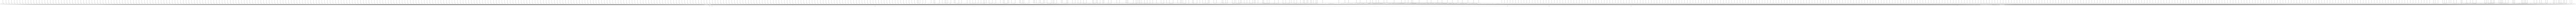

In [6]:
reduced_data_mapblocks.visualize("reduced_data_mapblocks", format="png")

As you can see, the task and data processing graph is very complex.
To ensure that the data is consistent, we're going to transform this dask-array into a raster on disk and display it on a map.

Now we can run the calculations using ``.compute()`` on the dask-array. The dask dashboard will start displaying information

In [7]:
%%time

result_mapblocks = reduced_data_mapblocks.compute()

CPU times: user 20.6 s, sys: 3.85 s, total: 24.4 s
Wall time: 34.6 s


As expected, the total processing time seems slow even though the task is fairly simple.

To make sure that the processing is consistent, we can transform the dask-array into a raster on the disk and display it on a map.


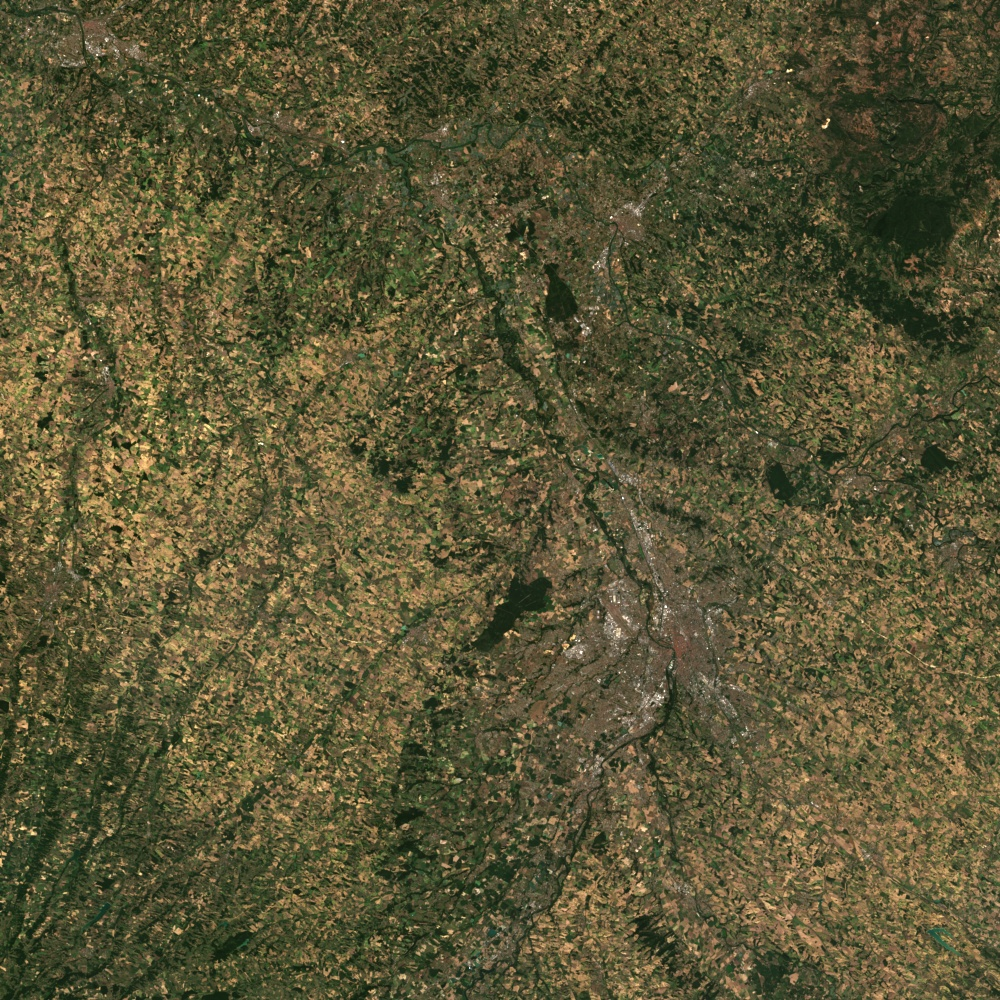

In [8]:
def create_raster(data: np.ndarray, output_file: Path, x_res, y_res, top_left_x, top_left_y, crs):
    transform = Affine.translation(top_left_x, top_left_y) * Affine.scale(x_res, -y_res)
    with rasterio.open(
            output_file, "w",
            driver="GTiff",
            height=data.shape[1],
            width=data.shape[2],
            count=data.shape[0],
            dtype=data.dtype,
            crs=crs,
            transform=transform
    ) as dst:
        dst.write(data)
        
output_file = Path("aggregation_reduction_mapblocks.tif")
result_mapblocks = np.moveaxis(result_mapblocks, -1, 0)
create_raster(result_mapblocks, output_file, x_res * scale_factor, y_res * scale_factor,
                  top_left_x, top_left_y, crs)
    
quicklook_img = f"{sentinel_2_dir}/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_QKL_ALL.jpg"
result_mapblocks = np.moveaxis(result_mapblocks, -1, 0)
folium_map = create_map_with_rasters(output_file, "Sentinel-2 resampled", quicklook_img)
folium_map


### Downscaling input data using dask.array.mean

This time, instead of using the ``map_blocks`` function, which maps any function to blocks of data, we're going to ask dask directly to use dask.array.mean on our block of data. As we want to do this on well-defined windows, we need to get the data into the right shape before applying dask's ``mean`` method.

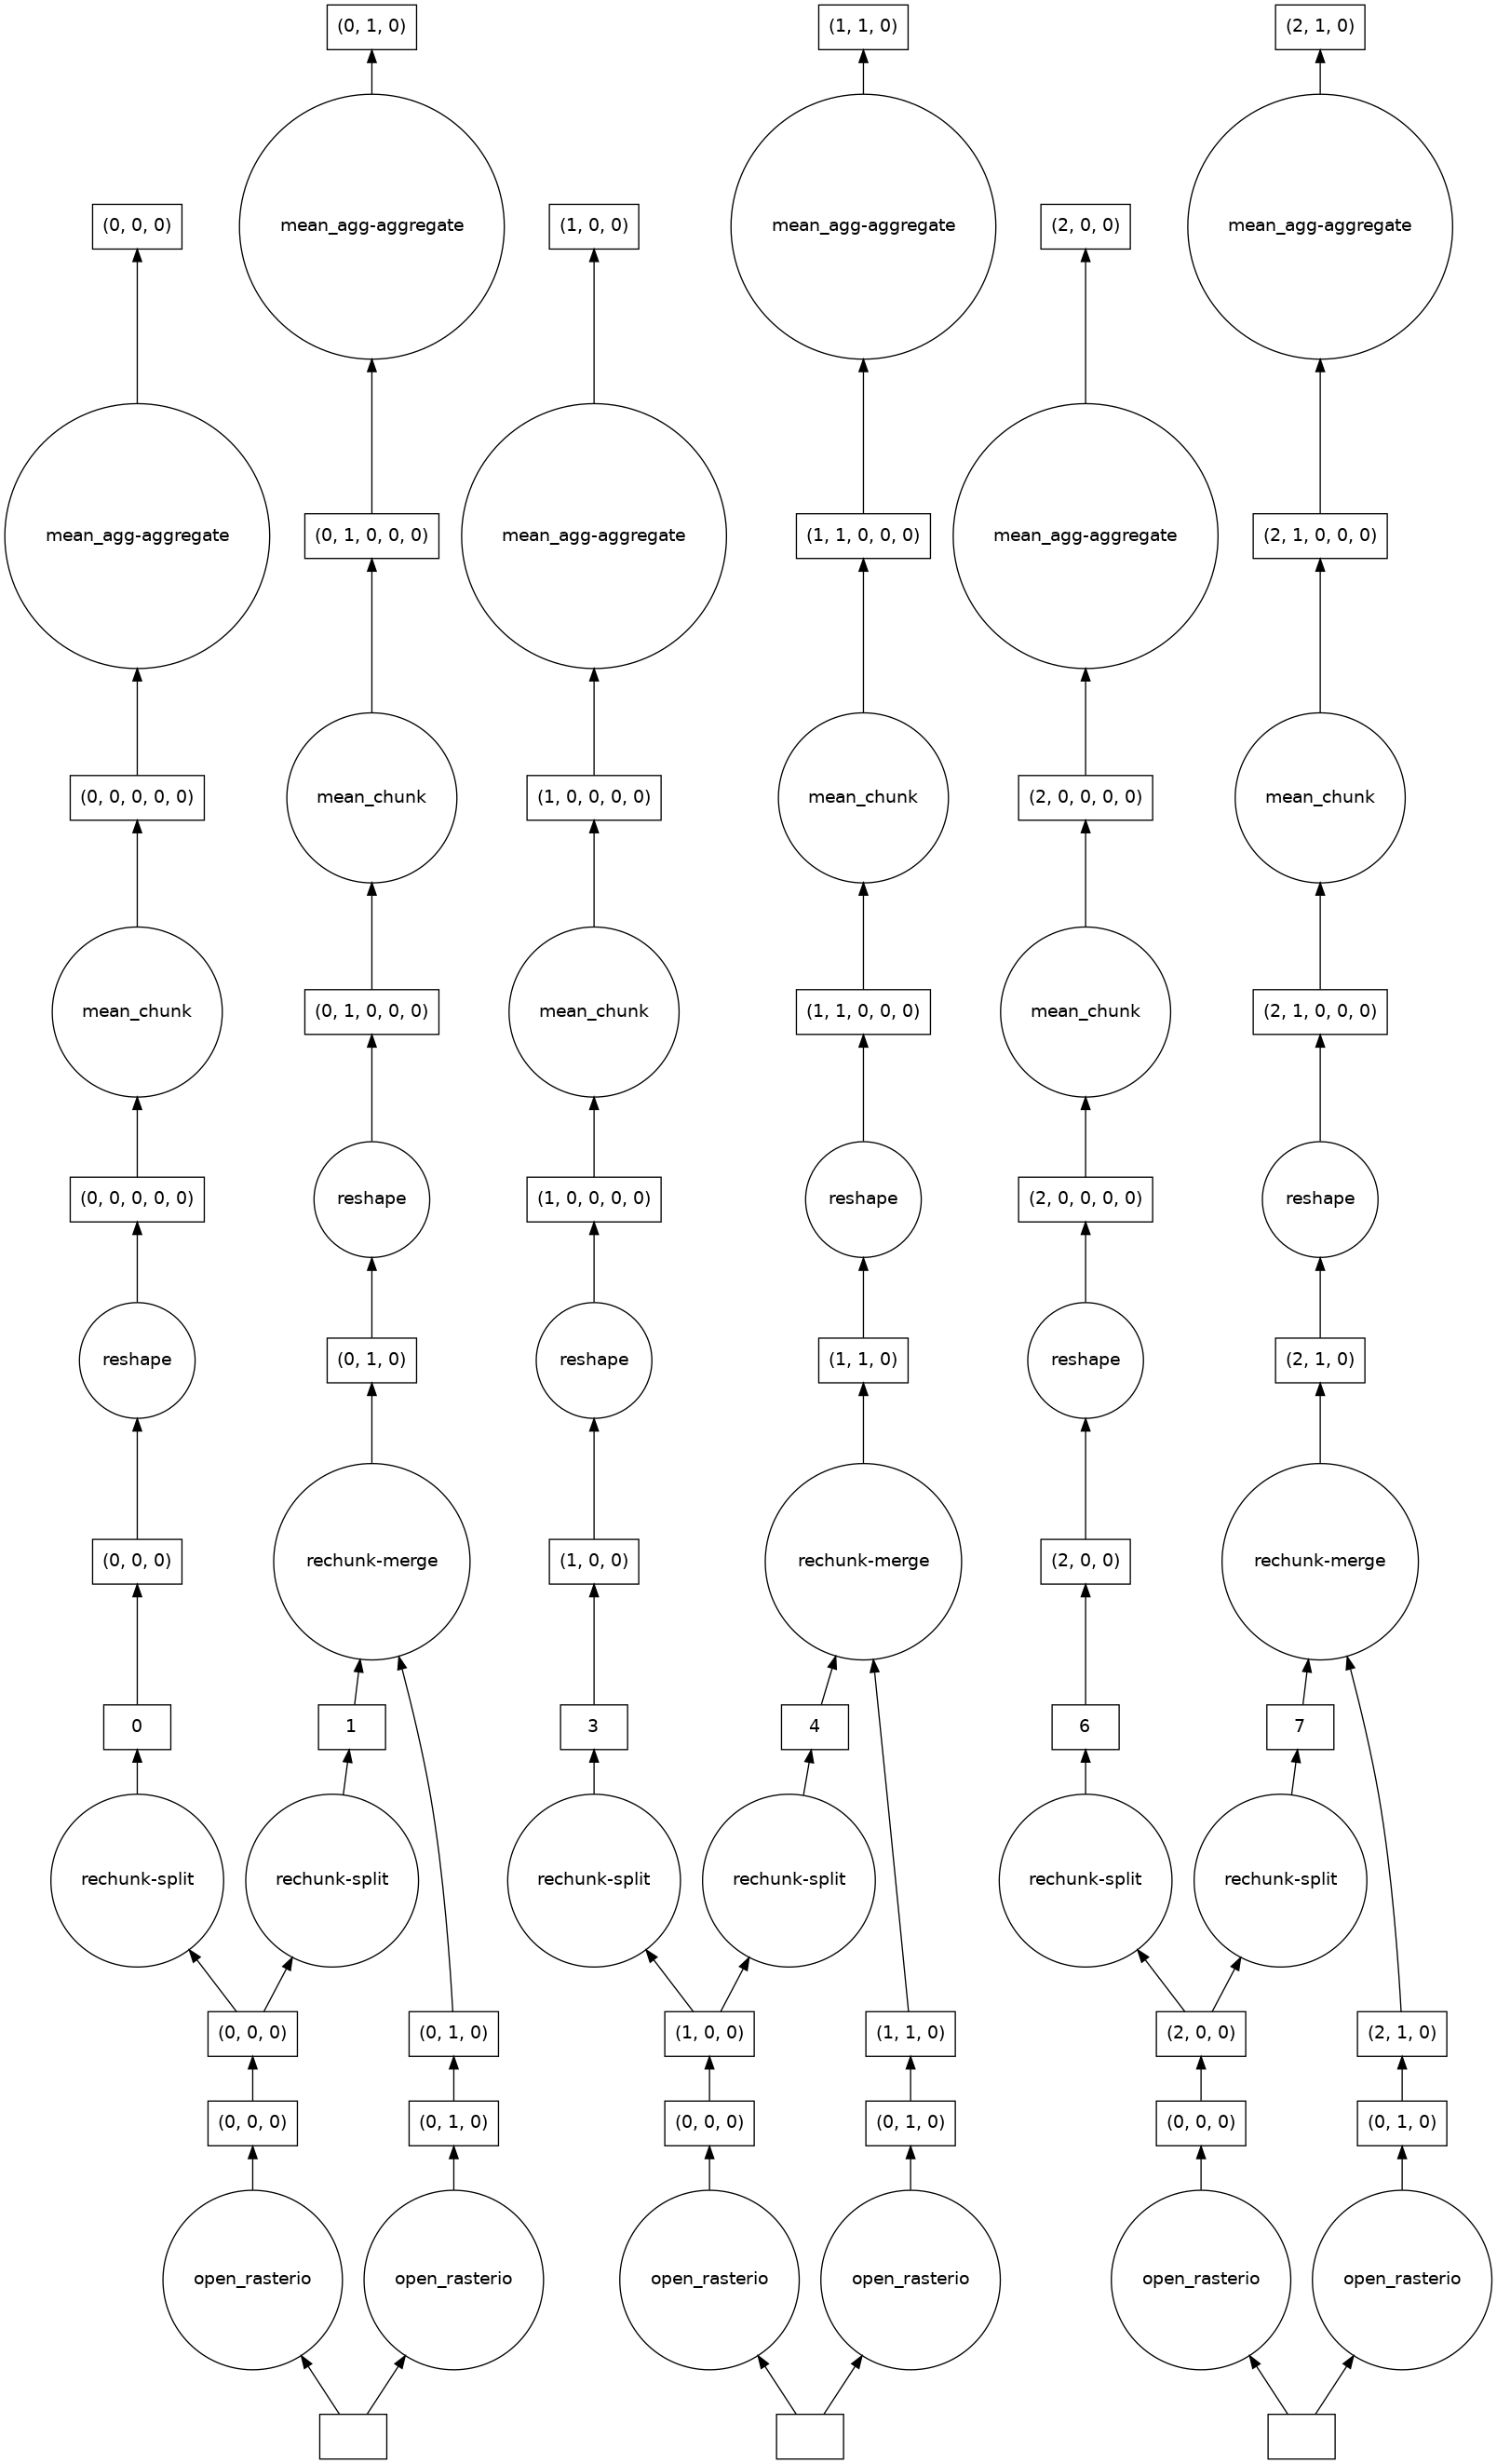

In [9]:
def apply_reduction_mean(data, downscale_factor):
    bands, rows, cols = data.shape
    expected_shape = (bands, int(cols/downscale_factor), downscale_factor, int(rows/downscale_factor), downscale_factor)
    rechunk_data = data.reshape(expected_shape)
    reduced_data = da.mean(rechunk_data, axis=(2,4))
    return reduced_data

scale_factor = 366
reduced_data = apply_reduction_mean(input_data_array, scale_factor)
reduced_data.visualize("reduced_data", format="png")

This time, the graph generated is less complex than the one generated by map_blocks. We can infer from this that the calculations will be faster.

In [10]:
%%time

result_mean = reduced_data.compute()

CPU times: user 269 ms, sys: 33.5 ms, total: 303 ms
Wall time: 908 ms



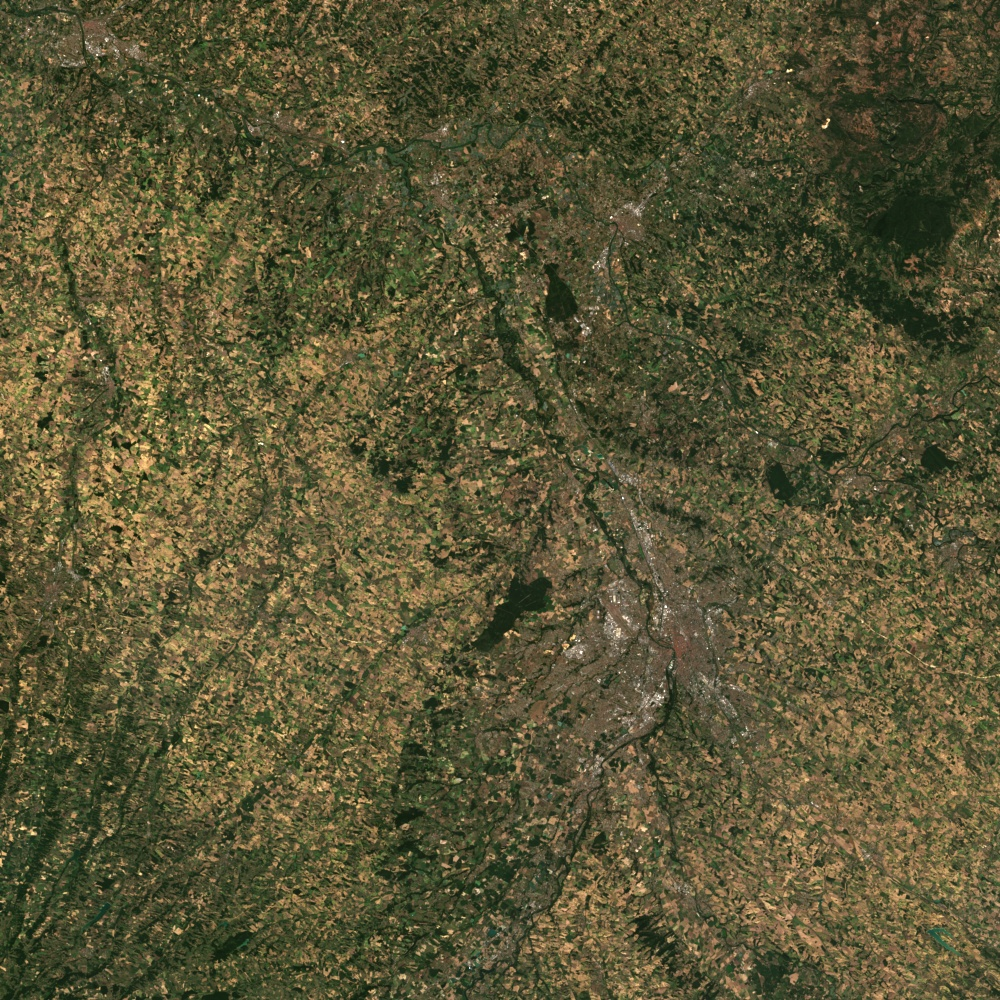

In [11]:
output_file = Path("aggregation_reduction.tif")
quicklook_img = f"{sentinel_2_dir}/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_QKL_ALL.jpg"
create_raster(result_mean, output_file, x_res * scale_factor, y_res * scale_factor,
                  top_left_x, top_left_y, crs)
folium_map = create_map_with_rasters(output_file, "Sentinel-2 resampled", quicklook_img)
folium_map



### First conclusions

We saw that using ``da.mean`` directly was much faster than using it via ``map_blocks``. We also generated the task graphs associated with each of the processes and found that the more complex the graph, the slower the computation.

In conclusion, it is important to study the task graph to make it as simple as possible.

In this tutorial we also let dask choose the size of the chunks when reading images ``reading_chunks = True`` at the start of the script. It's interesting to observe the behaviour of dask and to watch the complexity of the graphs evolve as a function of an imposed split and/or by changing the scale factor.

```python
reading_chunks = (1, 1000, 1000)
input_array = open_raster_and_get_metadata([s2_b4, s2_b3, s2_b2], reading_chunks)[0]
scale_factor = 180
reduced_data = apply_reduction_mean(input_array, scale_factor)
reduced_data.visualize("new_reduced_data", format="png")
```


## Calculation of the Average NDVI

In this example, we will use what we have learned to: 

1. Read the data from the disk and stack them.
2. Calculate the associated NDVI, which combines multi-band information into a single band.
3. Reduce the information by calculating the average NDVI within a window.
4. Write the resulting image to the disk.

First, let's read the data we need to perform the NDVI.

In [12]:
s2_b4 = f"{sentinel_2_dir}/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_FRE_B4.tif"
s2_b8 = f"{sentinel_2_dir}/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_FRE_B8.tif"
reading_chunks = True
input_data_array, x_res, y_res, top_left_x, top_left_y, crs = open_raster_and_get_metadata([s2_b4, s2_b8], reading_chunks)

When the data is read, we can express the NDVI calculation as if it were a numpy array. We add ``[None, :, :]`` to keep the shape as ``(bands, rows, cols)``. Then we can apply reduction on the dask.array and use ``compute()`` on it to triger the computation.

In [13]:
ndvi_array = (input_data_array[1] - input_data_array[0]) / (input_data_array[1] + input_data_array[0])[None, :, :]
mean_ndvi = apply_reduction_mean(ndvi_array, scale_factor)

In [14]:
%%time

mean_ndvi = mean_ndvi.compute()

CPU times: user 862 ms, sys: 74.4 ms, total: 936 ms
Wall time: 4.37 s



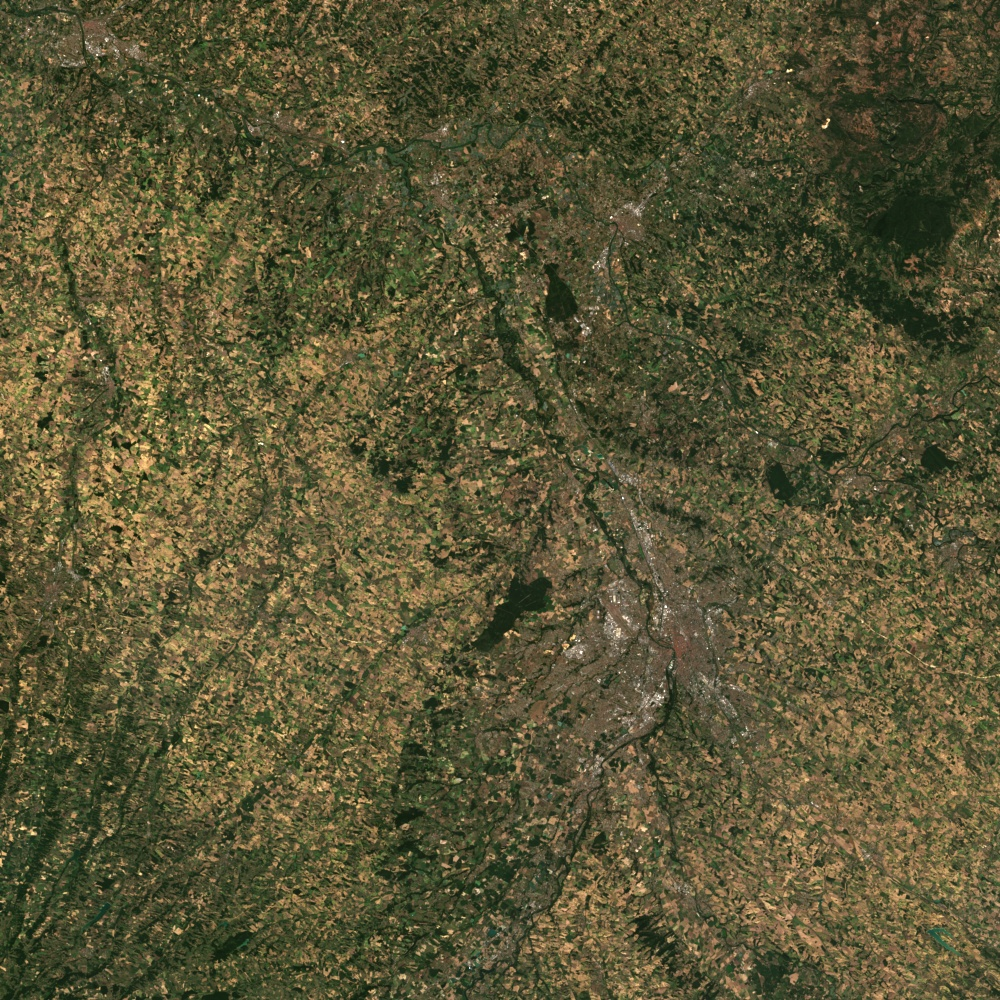
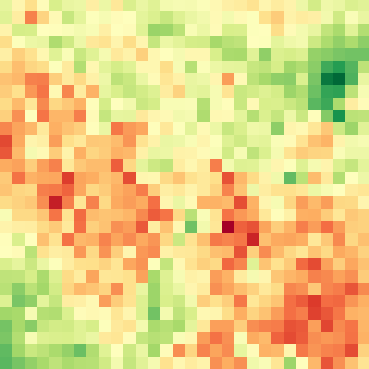

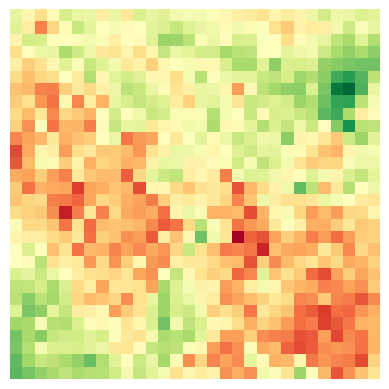

In [15]:
output_file = Path("ndvi_aggregation_reduction.tif")
quicklook_img = f"{sentinel_2_dir}/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1/SENTINEL2B_20240822-105857-973_L2A_T31TCJ_C_V3-1_QKL_ALL.jpg"
create_raster(mean_ndvi, output_file, x_res * scale_factor, y_res * scale_factor,
                  top_left_x, top_left_y, crs)
folium_map = create_map_with_rasters(output_file, "Sentinel-2 resampled", quicklook_img)
folium_map